In [7]:
import pymongo


In [44]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb= myclient['project']
congestion = mydb['congestion']
stop=mydb['stops']


In [9]:
import requests,json,random
# random reqId generator for post req get_approaching_veichles()
def s4():
    return ''.join([random.choice('0123456789abcdef') for x in range(4)])
def guid():
    return s4()+s4()+'-'+s4()+'-'+s4()+'-'+s4()+s4()+s4()

#req header 
headers={'content-type': 'application/json','accept':'application/json'}


class api:
    def __init__(self):
        self.baseurl="http://167.114.174.89:8080/"
        self.baseurl_tp="http://167.114.174.89:2080/"
        self.req_id=""
        self.stops=self.get_all_stoppages()["data"]
        
    #utility
    def get_stop_id_by_name(self,stop_name):
        for stop in self.stops:
            if stop["stopName"]==stop_name:
                return stop["stopId"]
        return "0"
    
    # Get req working all
    def get_all_routes(self):
        r = requests.get(self.baseurl+"app/routes/getAllRoutes.json")
        return json.loads(r.text)
        
    def get_all_stoppages(self):
        r = requests.get(self.baseurl+"app/stops/getAllStops.json")
        return json.loads(r.text)
        
    def get_last_update_time(self):
        r = requests.get(self.baseurl+"app/routes/getLastUpdateTime.json")
        return json.loads(r.text)
        
    def get_kolkata_traffic_update(self):
        r = requests.get(self.baseurl+"app/sm/kolkatatrafficupdate.json")
        return json.loads(r.text)
    
    
    # Post req . working n tested
    def get_approaching_vehicles(self,stop_id):
        data=json.dumps({'requestId':guid(),'stopId':stop_id})
        r=requests.post(self.baseurl+"app/travel/getApproachingVehicles.json",data=data,headers=headers)
        self.req_id=json.loads(r.text)['requestId']
        return json.loads(r.text)
        
    def get_vehicle_ETA(self,veichle_no):
        data=json.dumps({'vehicleNo':veichle_no})
        r=requests.post(self.baseurl+"app/eta/getVehicleETA.json",data=data,headers=headers)
        return json.loads(r.text)
        
    def get_vehicles_by_rec_boundary(self,rec):
        data=json.dumps({'pointNW':{'latitude':rec[0],'longitude':rec[1]},'pointSE':{'latitude':rec[2],'longitude':rec[3]}})
        r=requests.post(self.baseurl+"app/vehicles/getVehicleList.json",data=data,headers=headers)
        return json.loads(r.text)
        
    def get_stoppages_by_rec_boundary(self,rec):
        data=json.dumps({'pointNW':{'latitude':rec[0],'longitude':rec[1]},'pointSE':{'latitude':rec[2],'longitude':rec[3]}})
        r=requests.post(self.baseurl+"app/stops/getStopList.json",data=data,headers=headers)
        return json.loads(r.text)
    
    def find_nearest_stop(self,loc,dist):
        data=json.dumps({"location": {"latitude": loc[0],"longitude": loc[1]},"searchDistance": dist})
        r=requests.post(self.baseurl+"app/stops/getNearbyStops.json",data=data,headers=headers)
        return json.loads(r.text)
        
    def get_vehicle_pos(self,veichle_no):
        data=json.dumps({'vehicleNo':veichle_no})
        r=requests.post(self.baseurl+"app/vehicles/getVehicleByRegNo.json",data=data,headers=headers)
        return json.loads(r.text)
    
    def get_vehicle_by_route(self,route_code):
        data=json.dumps({ "routeCode": route_code })
        r=requests.post(self.baseurl+"app/vehicles/getVehicleByRoute.json",data=data,headers=headers)
        return json.loads(r.text)
        
    def get_trip_plans(self,from_stop,to_stop,hop_count):
        url_params="startStopName=" + from_stop + "&endStopName=" + to_stop + "&hopCount=" + str(hop_count)
        r=requests.get(self.baseurl_tp+"/app/tripplanner/routes?"+url_params)
        return json.loads(r.text)
    
    def get_route_path_bw_2_stops(self,route_code,from_stop_id,to_stop_id):
        data=json.dumps({"requestId":guid(),"routeCode":route_code,"startStopId":from_stop_id,"endStopId":to_stop_id})
        print data
        r=requests.post(self.baseurl+"app/paths/getPathByRoute.json",data=data,headers=headers)
        return json.loads(r.text)


In [10]:
a=api()

In [11]:
stops.find_one()

{u'_id': ObjectId('5ce3ad568fdd0f3819f8d7ae'),
 u'isJunction': u'Y',
 u'isValid': u'Y',
 u'locationType': u'TERMINAL',
 u'stopId': 1,
 u'stopLat': 22.642036,
 u'stopLon': 88.431122,
 u'stopName': u'AIRPORT (GATE NO.1)'}

In [12]:
stops.count()

/home/aisik/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


1686

In [24]:
from haversine import haversine
import time 
import threading
i=0
def get_stops():
    stops.delete_many({})
    stops.insert_many(a.get_all_stoppages()['data'])
    print stops.count()

def get_bus():
    localtime = time.localtime(time.time())
    global i
    d={}

    for stop in stops.find():
        d[stop['stopName'].replace('.','$')]={}
        d[stop['stopName'].replace('.','$')]['fast']=0
        d[stop['stopName'].replace('.','$')]['slow']=0
        d[stop['stopName'].replace('.','$')]['stopped']=0
    buses=a.get_vehicles_by_rec_boundary([22.993657,88.592600,22.360288,88.089977])['data']
    for bus in buses:
        if(bus['violatesPath'] == 'false' and bus['journeyStarted']== True):
            busPoint=(bus['lastLocation']['latitude'],bus['lastLocation']['longitude'])
            closeStop=stops.find_one()
            dist=haversine((closeStop['stopLat'],closeStop['stopLon']),busPoint)
            for stop in stops.find():
                if(haversine((stop['stopLat'],stop['stopLon']),busPoint)<dist):
                    closeStop=stop
                    dist=haversine((stop['stopLat'],stop['stopLon']),busPoint)
            if (dist<1.5):
                if(bus['speed']==0.0):
                    d[closeStop['stopName'].replace('.','$')]['stopped'] +=1
                elif(bus['speed']<5):
                    d[closeStop['stopName'].replace('.','$')]['slow'] +=1
                elif(bus['speed']>5):
                    d[closeStop['stopName'].replace('.','$')]['fast'] +=1
                else :
                    continue
    dic={}
    dic['hour']=localtime.tm_hour
    dic['min']=localtime.tm_min
    dic['day']=localtime.tm_mday
    dic['data']=d
    congestion.insert_one(dic)
    print localtime.tm_hour,localtime.tm_min
    threading.Timer(900.0, get_bus).start()
# get_stops()
# get_bus()

14 53
14 55


In [20]:
from apscheduler.scheduler import Scheduler

sched = Scheduler()
sched.start()

def some_job():
    print "Every 10 seconds"

sched.add_interval_job(some_job, seconds = 900)

In [68]:
import time
lt=time.localtime(time.time())
lt.tm_mday

21

In [26]:
hour=[]
day=[]
j=0
for i in liveloc.find():
    try:
        hour.append(i['properties']['hour'])
        day.append(i['properties']['day'])
        hour=list(set(hour))
        day=list(set(day))
    except:
        hour.append(i['hour'])
        day.append(i['day'])
        hour=list(set(hour))
        day=list(set(day))

In [26]:
congestion.count()

/home/aisik/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


48

18 22
18 24
18 37
18 39
18 53
18 55
19 8
19 10


In [32]:
congestion.find_one()

{u'_id': ObjectId('5ce3aa558fdd0f361807fbed'),
 u'data': {u'BALLYGUNGE STATION': {u'fast': 1, u'slow': 0, u'stopped': 2},
  u'GANADIPAYAN BUS STAND': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'TALPUKUR BAZAR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'HARAHARITALA': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'METIAKHALI BAZAR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BRAMBHAN PARA BUS STOP': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BELGACHIA (HOWRAH)': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'SHAKTIGARH': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'DATTA PARA': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BASIRHAT TRIMOHINI': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'KOTHARI HOSPITAL': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BALLY GHAT': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'KALYANPUR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'SANKRAIL STN$': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'PAIKPARA BUS STAND': {u'fast': 1, u'slow': 0, u'stopped': 0},

In [74]:
print maxi,mini

5572 -1


In [30]:
d={}
for data in congestion.find_one()['data'].keys():
    d[data]=0

In [72]:
for c in congestion.find():
    for k in d.keys():
        try:
            d[k] +=2*c['data'][k]['stopped']+c['data'][k]['slow']/c['data'][k]['fast']
        except:
            d[k]+=0

In [73]:
maxi=0
mini=1000
for x in d.keys():
    if (mini>d[x]):
        mini=d[x]
    if(maxi<d[x]):
        maxi=d[x]

In [75]:
x=[]
y=[]
colors=[]
area=[]
for s in stop.find():
    x.append(s['stopLon'])
    y.append(s['stopLat'])
    try:
        colors.append((d[s['stopName'].replace('.','$')]+1))
        area.append((d[s['stopName'].replace('.','$')]+1))
    except:
        area.append(0)
        colors.append(0)

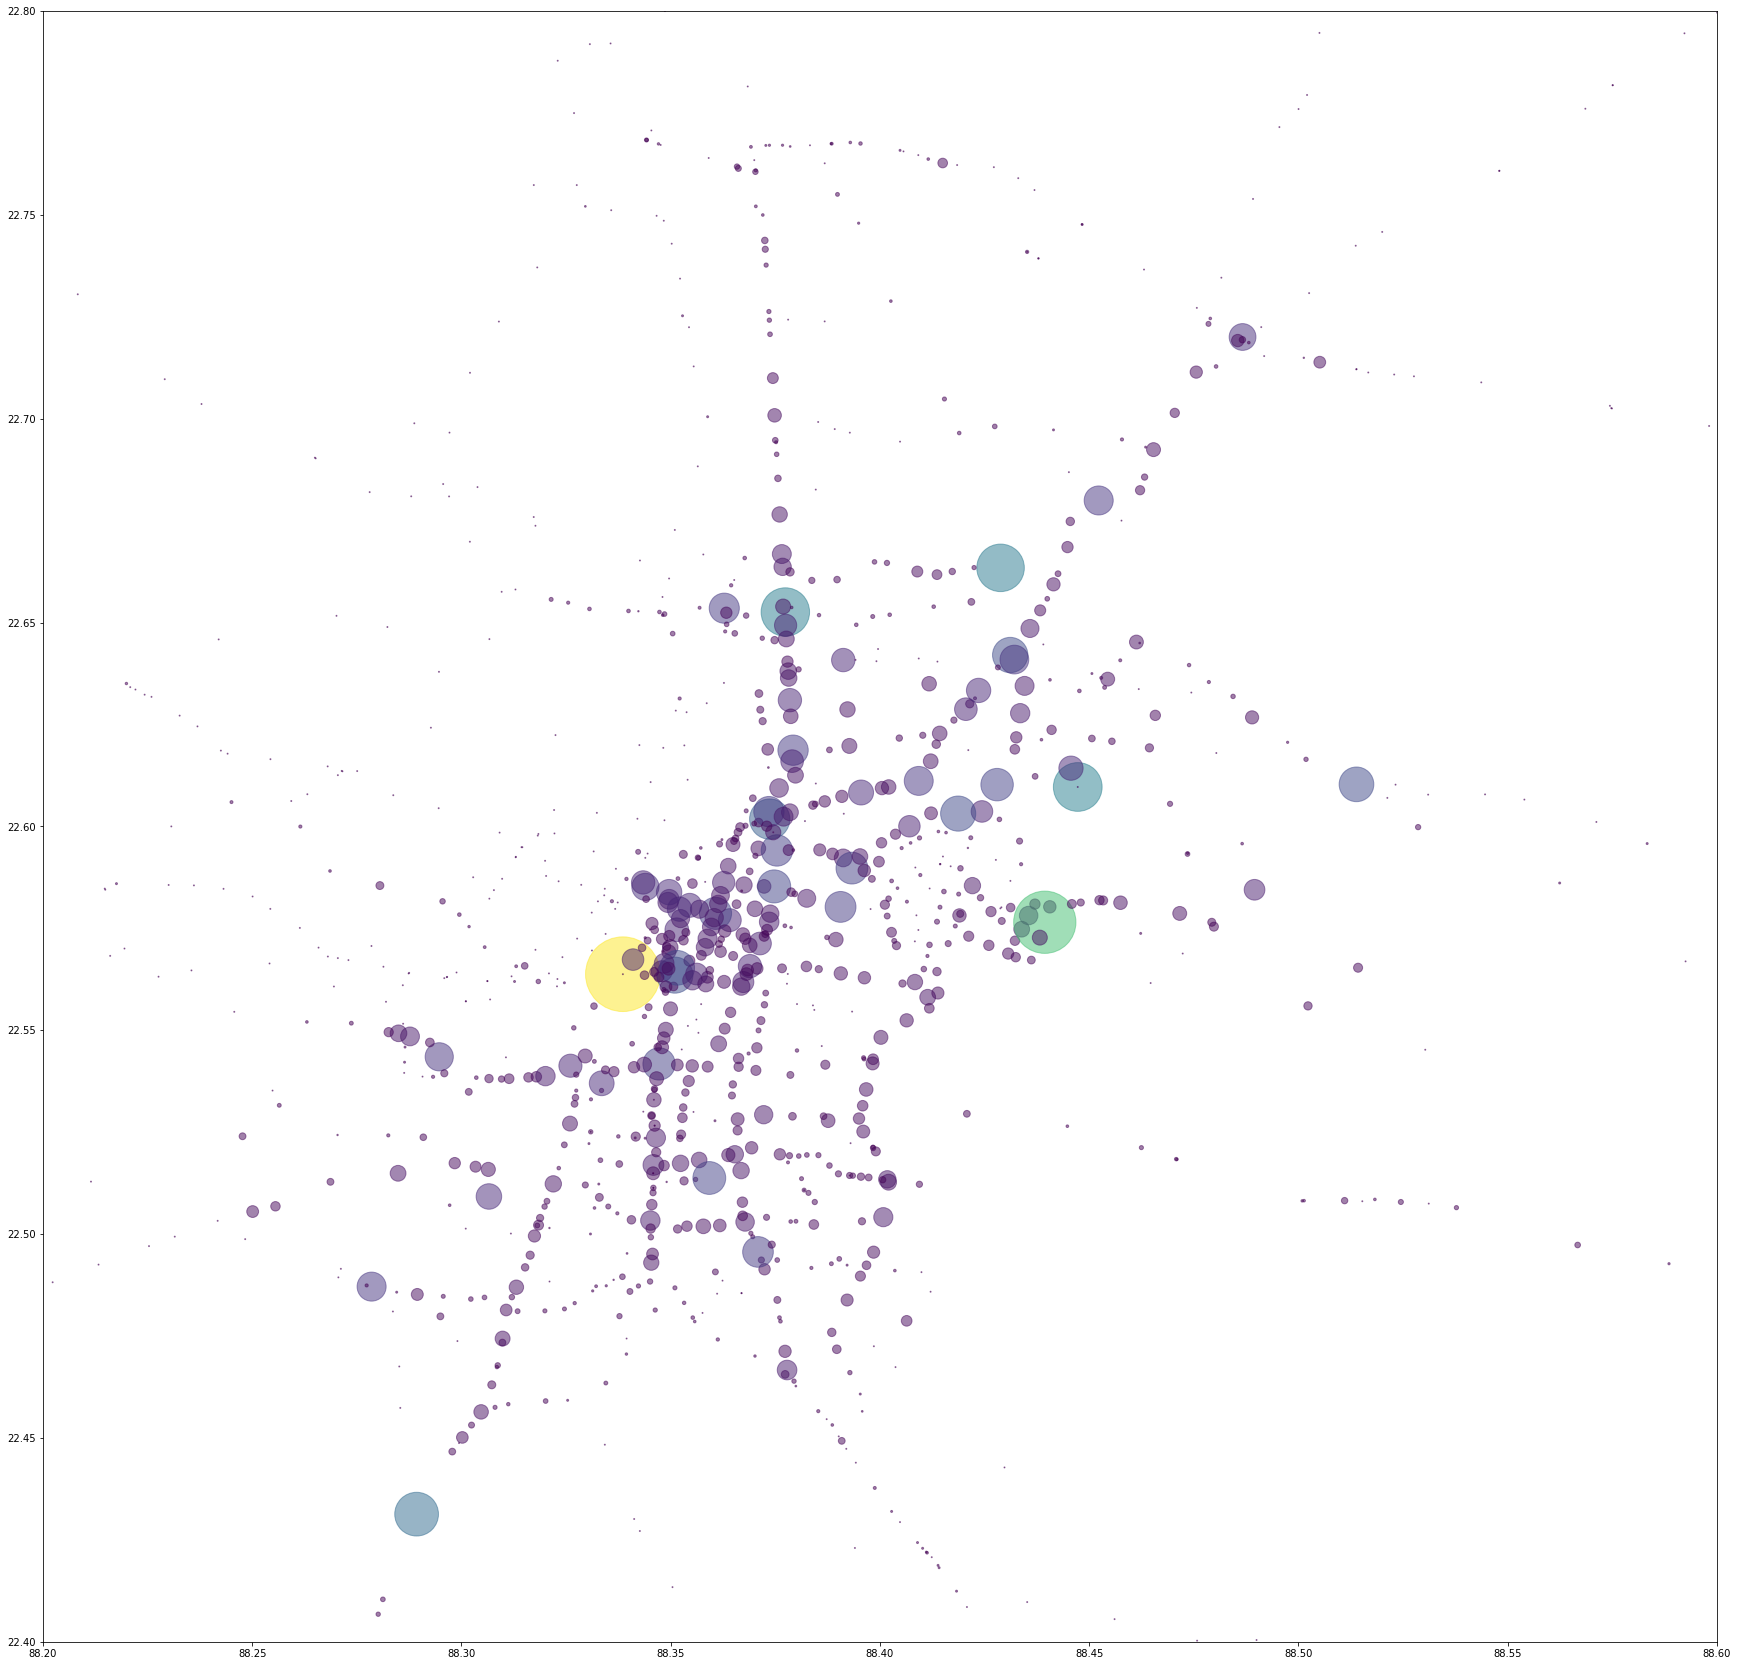

19 54
19 56
20 9
20 11


Exception in thread Thread-64:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 1073, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-24-124e5ac01c49>", line 20, in get_bus
    buses=a.get_vehicles_by_rec_boundary([22.993657,88.592600,22.360288,88.089977])['data']
  File "<ipython-input-9-cf9840a9e378>", line 58, in get_vehicles_by_rec_boundary
    r=requests.post(self.baseurl+"app/vehicles/getVehicleList.json",data=data,headers=headers)
  File "/usr/local/lib/python2.7/dist-packages/requests/api.py", line 112, in post
    return request('post', url, data=data, json=json, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/requests/api.py", line 58, in request
    return session.request(method=method, url=url, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/requests/sessions.py", line 508, in request
    resp = self.send(prep,

In [76]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(19680801)

axes = plt.axes()
axes.set_xlim([88.2,88.6])
axes.set_ylim([22.4,22.8])
# N = 50
# x = np.random.rand(N)
# y = np.random.rand(N)
# colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.rcParams["figure.figsize"] = (30,30)
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

In [50]:
plt.show()

In [53]:
for bus in buses1:
    if(bus['vehicle']['vehicleRegNo']=='WB19F2885'):
        break

In [118]:
d={}
bal=[]
for stop in stops.find():
    d[stop['stopName'].replace('.','$')]={}
    d[stop['stopName'].replace('.','$')]['fast']=0
    d[stop['stopName'].replace('.','$')]['slow']=0
    d[stop['stopName'].replace('.','$')]['stopped']=0
buses=a.get_vehicles_by_rec_boundary([22.993657,88.592600,22.360288,88.089977])['data']
for bus in buses:
    if(bus['violatesPath'] == 'false' and bus['journeyStarted']== True):
        busPoint=(bus['lastLocation']['latitude'],bus['lastLocation']['longitude'])
        closeStop=stops.find_one()
        dist=haversine((closeStop['stopLat'],closeStop['stopLon']),busPoint)
        for stop in stops.find():
            if(haversine((stop['stopLat'],stop['stopLon']),busPoint)<dist):
                closeStop=stop
                dist=haversine((stop['stopLat'],stop['stopLon']),busPoint)
        if (dist<1.5):
            if(closeStop['stopName']=='BALLYGUNGE STATION'):
                bal.append(bus)
            if(bus['speed']==0.0):
                d[closeStop['stopName'].replace('.','$')]['stopped'] +=1
            elif(bus['speed']<5):
                d[closeStop['stopName'].replace('.','$')]['slow'] +=1
            elif(bus['speed']>5):
                d[closeStop['stopName'].replace('.','$')]['fast'] +=1
            else :
                continue

In [18]:
congestion.find().count()

/home/aisik/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


6

13 10


In [119]:
for b in bal:
    print b['vehicle']['vehicleRegNo']

WB051795
12 11


In [129]:
sums=0
for k in congestion.find()[50]['data'].keys():
    sums +=d[k]['fast']+d[k]['slow']+d[k]['stopped']
print sums


874
12 39
12 41


In [6]:
congestion.count()

/home/aisik/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


4

In [5]:
congestion.find_one()

{u'_id': ObjectId('5ce3aa558fdd0f361807fbed'),
 u'data': {u'BALLYGUNGE STATION': {u'fast': 1, u'slow': 0, u'stopped': 2},
  u'GANADIPAYAN BUS STAND': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'TALPUKUR BAZAR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'HARAHARITALA': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'METIAKHALI BAZAR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BRAMBHAN PARA BUS STOP': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BELGACHIA (HOWRAH)': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'SHAKTIGARH': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'DATTA PARA': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BASIRHAT TRIMOHINI': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'KOTHARI HOSPITAL': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'BALLY GHAT': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'KALYANPUR': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'SANKRAIL STN$': {u'fast': 0, u'slow': 0, u'stopped': 0},
  u'PAIKPARA BUS STAND': {u'fast': 1, u'slow': 0, u'stopped': 0},